CS 175 Final Project: Classifying Toxic Comments

Team AMA

#### Loading the Data and Cleaning

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import re
np.random.seed(0)

In [2]:
import nltk
nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))

re_punc = re.compile(r'["\'#-]') #these should not be parsed as spaces (others special chars are)
re_alpha = re.compile(r'[a-zA-Z]+')

# comment text has to be cleaned up, there's stuff like urls and ip addresses
def prepareText(line):
    #Cleaning up comments
    no_punc = re_punc.sub('',str(line))
    tokens = re_alpha.findall(no_punc.lower())
    return ' '.join(token for token in tokens if token not in stop_words).lstrip()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\m-public\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
## example case
#c = "You are gay or antisemmitian? \n\nArchangel WHite Tiger\n\nMeow! Greetingshhh!\n\nUh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone...\n\n1 - If you are anti-semitian, than shave your head bald and go to the skinhead meetings!\n\n2 - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals!\n\n3 - First and last warning, you fucking gay - I won't appreciate if any more nazi shwain would write in my page! I don't wish to talk to you anymore!\n\nBeware of the Dark Side!"
#prepareText(c)

In [4]:
classes = ['toxic','severe_toxic','obscene', 'threat', 'insult', 'identity_hate']

In [5]:
"""split the data into non toxic vs toxic comments. create new dataset with the same amount of nontoxic to toxic corpus."""
def balance_data(df, mini=False):
    '''use after transforming comments'''
    labels = train.loc[:, 'toxic':'identity_hate']  
    non_toxic = df.loc[~labels.any(axis='columns')]
    toxic = df.loc[labels.any(axis='columns')]
    n_toxic = len(toxic)
    
    non_toxic_trimmed = non_toxic.sample(n_toxic)
    if mini: toxic = toxic.sample(n_toxic // 10)
    return pd.concat([non_toxic_trimmed,toxic], axis=0)

In [6]:
train = pd.read_csv('data/train.csv')
train['comment_text'] = train['comment_text'].apply(prepareText)
x = train['comment_text']

#As seen below, y pulls the columns containing the labels for each text comment in the dataset
y = train.loc[:, 'toxic':'identity_hate']  
#print(y)

In [7]:
train_balanced = balance_data(train)
x_b = train_balanced['comment_text']
y_b = train_balanced.loc[:, 'toxic':'identity_hate']

In [8]:
train_mini = balance_data(train, mini=True)
x_m = train_mini['comment_text']
y_m = train_mini.loc[:, 'toxic':'identity_hate']

In [9]:
train_balanced.shape

(32450, 8)

### Basic / Naive Bayes Logistic Model

In [10]:
from sklearn.feature_extraction.text import *
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

In [11]:
X_train, Xt, Y_train, Yt = train_test_split(x,y, random_state=26)
X_test, X_val, Y_test, Y_val = train_test_split(Xt, Yt, test_size=0.5, random_state=26)
#print(X_train)

# create Bag of Words array (might use a Tf-idf vectorizer instead of counts later
#        as importance of words seems relevant for this problem
vectorizer = CountVectorizer(stop_words='english', min_df=0.01, ngram_range=(1,1))
X_tr = vectorizer.fit_transform(X_train)
print(X_tr.shape)
print(Y_train.shape)
X_t = vectorizer.transform(X_test)
#print(X_test)

(119678, 401)
(119678, 6)


In [12]:
#repeat for balanced
X_train_b, Xt_b, Y_train_b, Yt_b = train_test_split(x_b,y_b, random_state=26)
X_test_b, X_val_b, Y_test_b, Y_val_b = train_test_split(Xt_b, Yt_b, test_size=0.5, random_state=26)

X_tr_b = vectorizer.transform(X_train_b)
print(X_tr_b.shape)
print(Y_train_b.shape)
X_t_b = vectorizer.transform(X_test_b)
#print(X_test)

(24337, 401)
(24337, 6)


In [13]:
#repeat for mini
X_train_m, Xt_m, Y_train_m, Yt_m = train_test_split(x_m,y_m, random_state=26)
X_test_m, X_val_m, Y_test_m, Y_val_m = train_test_split(Xt_m, Yt_m, test_size=0.5, random_state=26)

X_tr_m = vectorizer.transform(X_train_m)
print(X_tr_m.shape)
print(Y_train_m.shape)
X_t_m = vectorizer.transform(X_test_m)
#print(X_test)

(13385, 401)
(13385, 6)


In [14]:
# Current plan for simple classifier is to run a logistic regression classifier on each label
# If this is too difficult right now then we'll try it just on the most common labels
#using this link for help: https://www.kaggle.com/code/adamschroeder/countvectorizer-tfidfvectorizer-predict-comments#TfidfVectorizer----Brief-Tutorial
def train_basic(Xtr, Ytr, Xte, Yte, test_features):
    classifiers = dict()
    scores = {c:dict() for c in classes}
    for label in classes:
        print("Logistic Regression for {}".format(label))
        #run logistic regression for each class
        y_tr = Ytr[label]
        y_te = Yte[label]
        
        label_classifier = LogisticRegression(solver='sag', C=10)
        label_classifier.fit(Xtr, y_tr)
        classifiers[label] = label_classifier
        
        loss = np.mean(cross_val_score(label_classifier, Xtr, y_tr, cv=5, scoring='neg_log_loss'))
        print("Log loss score: {}".format(loss))
        scores[label]['log'] = loss
        
        accuracy = np.mean(cross_val_score(label_classifier, Xtr, y_tr, cv = 5, scoring = 'accuracy'))
        print("Accuracy score: {}".format(accuracy))
        scores[label]['acc'] = accuracy
        
        y_prediction = label_classifier.predict(test_features)
        y_probability = label_classifier.predict_proba(test_features)[:, 1]
        auc = metrics.roc_auc_score(y_te, y_probability)
        print("ROC AUC score: {}".format(auc))
        scores[label]['auc'] = auc
        
        #print(confusion_matrix(y_te, y_prediction))
        #print(classification_report(y_te, y_prediction))
    return classifiers, scores

In [15]:
%%time
basic_classifiers, basic_scores = train_basic(X_tr,Y_train, X_test, Y_test, X_t)
%store basic_classifiers

Logistic Regression for toxic
Log loss score: -0.35540599139288387
Accuracy score: 0.919107927525417
ROC AUC score: 0.7604606683655173
Logistic Regression for severe_toxic
Log loss score: -0.20784901081994986
Accuracy score: 0.9897642033934375
ROC AUC score: 0.7645450863108653
Logistic Regression for obscene
Log loss score: -0.28453531408137916
Accuracy score: 0.9584886006860158
ROC AUC score: 0.7649535855523228
Logistic Regression for threat
Log loss score: -0.18955186877861466
Accuracy score: 0.9970253514978736
ROC AUC score: 0.6632039494535094
Logistic Regression for insult
Log loss score: -0.2834260941818735
Accuracy score: 0.954110208868381
ROC AUC score: 0.7238880040716342
Logistic Regression for identity_hate
Log loss score: -0.20226665782161582
Accuracy score: 0.9910760544936208
ROC AUC score: 0.6590697819145006
Stored 'basic_classifiers' (dict)
Wall time: 5min 18s


In [16]:
%%time
basic_classifiers_balanced, balanced_scores = train_basic(X_tr_b, Y_train_b, X_test_b, Y_test_b, X_t_b)
%store basic_classifiers_balanced

Logistic Regression for toxic
Log loss score: -0.6102808242943674
Accuracy score: 0.7175890773456439
ROC AUC score: 0.8226167820965613
Logistic Regression for severe_toxic
Log loss score: -0.4321771779255754
Accuracy score: 0.951884043241261
ROC AUC score: 0.7302513274764929
Logistic Regression for obscene
Log loss score: -0.5518477759890607
Accuracy score: 0.8238073258115334
ROC AUC score: 0.7894721723857018
Logistic Regression for threat
Log loss score: -0.3815746420097917
Accuracy score: 0.9861527814896796
ROC AUC score: 0.6273633088006944
Logistic Regression for insult
Log loss score: -0.5601830753343835
Accuracy score: 0.7895799676489105
ROC AUC score: 0.7240221912216797
Logistic Regression for identity_hate
Log loss score: -0.4184202456515532
Accuracy score: 0.9561162079768852
ROC AUC score: 0.6462649089767735
Stored 'basic_classifiers_balanced' (dict)
Wall time: 31.7 s


In [17]:
%%time
basic_classifiers_mini, mini_scores = train_basic(X_tr_m, Y_train_m, X_test_m, Y_test_m, X_t_m)
%store basic_classifiers_mini

Logistic Regression for toxic
Log loss score: -0.3829188327070937
Accuracy score: 0.9242435562196489
ROC AUC score: 0.6957647605020493
Logistic Regression for severe_toxic
Log loss score: -0.2682512330001349
Accuracy score: 0.9912588718714979
ROC AUC score: 0.774631097364521
Logistic Regression for obscene
Log loss score: -0.3319897101397337
Accuracy score: 0.9601793051923796
ROC AUC score: 0.7357654735593254
Logistic Regression for threat
Log loss score: -0.2589296116666976
Accuracy score: 0.9978333955920806
ROC AUC score: 0.7108778625954199
Logistic Regression for insult
Log loss score: -0.32339248926984265
Accuracy score: 0.9609264101606275
ROC AUC score: 0.727461207120245
Logistic Regression for identity_hate
Log loss score: -0.26587155460540723
Accuracy score: 0.9929772132984684
ROC AUC score: 0.7053129221071588
Stored 'basic_classifiers_mini' (dict)
Wall time: 18.3 s


In [18]:
mini_scores_pd = pd.DataFrame(mini_scores)

In [19]:
mini_scores_pd

,toxic,severe_toxic,obscene,threat,insult,identity_hate
log,-0.382919,-0.268251,-0.331990,-0.258930,-0.323392,-0.265872
acc,0.924244,0.991259,0.960179,0.997833,0.960926,0.992977
auc,0.695765,0.774631,0.735765,0.710878,0.727461,0.705313


### Advanced Model

In [20]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [21]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=4000,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True,
    split=' ',
    char_level=False)

def tokenize(X, fit=True):
    if fit: tokenizer.fit_on_texts(X)
    sequence = tokenizer.texts_to_sequences(X)
    return pad_sequences(sequence,maxlen=50)

In [22]:
X_train_seq = tokenize(X_train)
X_val_seq = tokenize(X_val)
X_test_seq = tokenize(X_test, False)

In [23]:
X_train_seq_b = tokenize(X_train_b)
X_val_seq_b = tokenize(X_val_b)
X_test_seq_b = tokenize(X_test_b, False)

In [24]:
X_train_seq_m = tokenize(X_train_m)
X_val_seq_m = tokenize(X_val_m)
X_test_seq_m = tokenize(X_test_m, False)

In [25]:
def train_advanced(X_tr, Y_tr, X_v, Y_v, epochs=5):
    model = Sequential()
    model.add(Embedding(4000, 300, input_length=X_tr.shape[1]))
    model.add(LSTM(256))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(6, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
    history_obj = model.fit(X_tr,np.asarray(Y_tr),batch_size=300,epochs=epochs, validation_data=(X_v, np.asarray(Y_v)))
    return model, history_obj

In [26]:
advanced, history_advanced = train_advanced(X_train_seq, Y_train, X_val_seq, Y_val)
#%store advanced history_advanced

Epoch 1/5
399/399 [==============================] - 357s 889ms/step - loss: 0.0953 - accuracy: 0.9811 - val_loss: 0.2058 - val_accuracy: 0.9940
Epoch 2/5
399/399 [==============================] - 355s 890ms/step - loss: 0.0558 - accuracy: 0.9942 - val_loss: 0.2231 - val_accuracy: 0.9939
Epoch 3/5
399/399 [==============================] - 358s 896ms/step - loss: 0.0518 - accuracy: 0.9942 - val_loss: 0.2170 - val_accuracy: 0.9936
Epoch 4/5
399/399 [==============================] - 359s 900ms/step - loss: 0.0490 - accuracy: 0.9922 - val_loss: 0.2228 - val_accuracy: 0.9902
Epoch 5/5
399/399 [==============================] - 337s 845ms/step - loss: 0.0466 - accuracy: 0.9728 - val_loss: 0.2482 - val_accuracy: 0.9704


In [27]:
advanced_b, history_advanced_b = train_advanced(X_train_seq_b, Y_train_b, X_val_seq_b, Y_val_b, 10)
#%store advanced_b history_advanced_b

Epoch 1/10
82/82 [==============================] - 67s 786ms/step - loss: 0.3602 - accuracy: 0.9477 - val_loss: 0.4369 - val_accuracy: 0.9677
Epoch 2/10
82/82 [==============================] - 64s 780ms/step - loss: 0.2164 - accuracy: 0.9713 - val_loss: 0.4046 - val_accuracy: 0.9680
Epoch 3/10
82/82 [==============================] - 64s 783ms/step - loss: 0.1908 - accuracy: 0.9694 - val_loss: 0.4391 - val_accuracy: 0.9680
Epoch 4/10
82/82 [==============================] - 64s 784ms/step - loss: 0.1807 - accuracy: 0.9679 - val_loss: 0.4278 - val_accuracy: 0.9618
Epoch 5/10
82/82 [==============================] - 65s 791ms/step - loss: 0.1734 - accuracy: 0.9542 - val_loss: 0.4768 - val_accuracy: 0.9021
Epoch 6/10
82/82 [==============================] - 64s 778ms/step - loss: 0.1640 - accuracy: 0.9461 - val_loss: 0.4764 - val_accuracy: 0.9236
Epoch 7/10
82/82 [==============================] - 63s 770ms/step - loss: 0.1561 - accuracy: 0.9306 - val_loss: 0.5254 - val_accuracy: 0.9305

In [28]:
advanced_m, history_advanced_m = train_advanced(X_train_seq_m, Y_train_m, X_val_seq_m, Y_val_m, 20)
#%store advanced_m history_advanced_m

Epoch 1/20
45/45 [==============================] - 40s 829ms/step - loss: 0.2019 - accuracy: 0.8812 - val_loss: 0.1253 - val_accuracy: 0.9951
Epoch 2/20
45/45 [==============================] - 38s 838ms/step - loss: 0.1217 - accuracy: 0.9715 - val_loss: 0.1196 - val_accuracy: 0.9565
Epoch 3/20
45/45 [==============================] - 35s 782ms/step - loss: 0.0871 - accuracy: 0.9533 - val_loss: 0.1298 - val_accuracy: 0.9525
Epoch 4/20
45/45 [==============================] - 35s 778ms/step - loss: 0.0562 - accuracy: 0.9934 - val_loss: 0.1352 - val_accuracy: 0.9955
Epoch 5/20
45/45 [==============================] - 35s 778ms/step - loss: 0.0464 - accuracy: 0.9949 - val_loss: 0.1624 - val_accuracy: 0.9955
Epoch 6/20
45/45 [==============================] - 35s 773ms/step - loss: 0.0424 - accuracy: 0.9845 - val_loss: 0.1627 - val_accuracy: 0.9955
Epoch 7/20
45/45 [==============================] - 35s 777ms/step - loss: 0.0393 - accuracy: 0.9866 - val_loss: 0.1766 - val_accuracy: 0.9848

In [29]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
def plot_loss(history_obj, title):
    plt.figure()
    plt.title(title)
    plt.ylabel('Loss', fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.plot(history_obj.history['loss'], color='b', label='Training Loss')
    plt.plot(history_obj.history['val_loss'], color='r', label='Validation Loss')
    plt.legend(loc='upper right')
    plt.show()

In [30]:
#%store -r history_advanced history_advanced_b

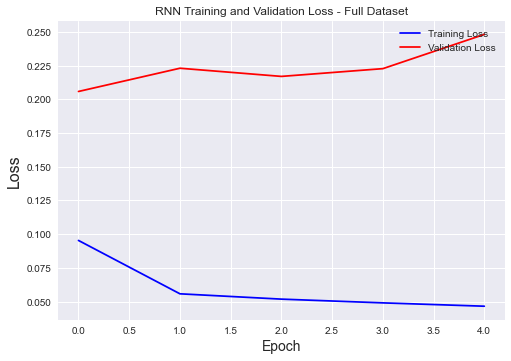

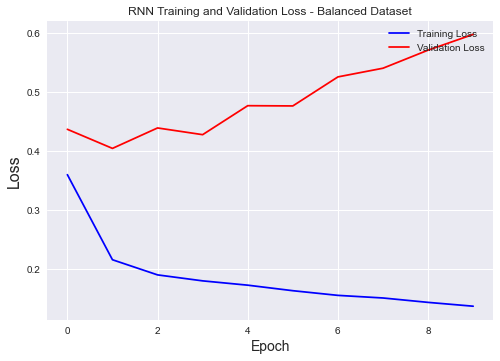

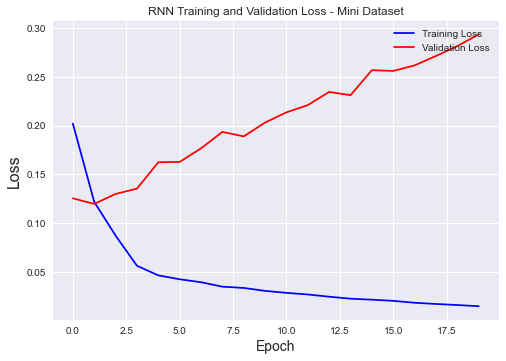

In [31]:
plot_loss(history_advanced, 'RNN Training and Validation Loss - Full Dataset')
plot_loss(history_advanced_b, 'RNN Training and Validation Loss - Balanced Dataset')
plot_loss(history_advanced_m, 'RNN Training and Validation Loss - Mini Dataset')

In [32]:
def plot_accuracy(history_obj, title):
    loss_train = history_obj.history['accuracy']
    loss_val = history_obj.history['val_accuracy']
    epochs = range(1,len(loss_train)+1)
    plt.plot(epochs, loss_train, 'g', label='Training accuracy')
    plt.plot(epochs, loss_val, 'b', label='validation accuracy')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

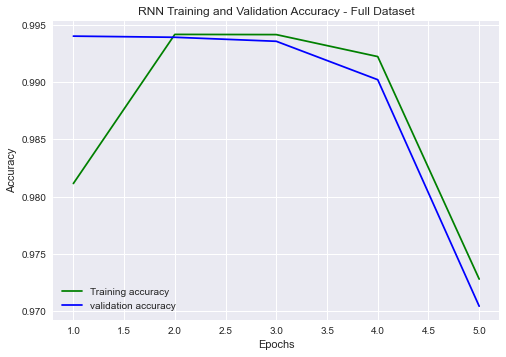

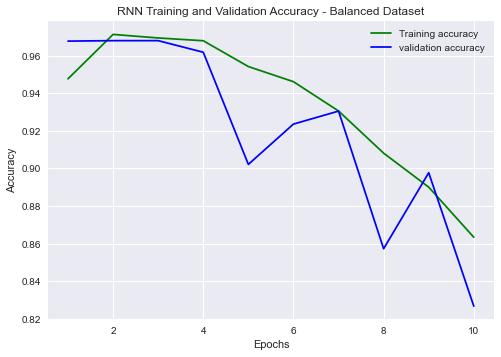

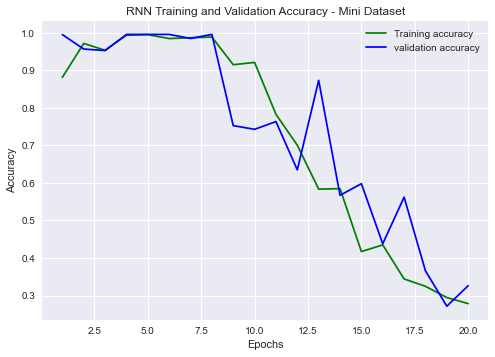

In [33]:
plot_accuracy(history_advanced, 'RNN Training and Validation Accuracy - Full Dataset')
plot_accuracy(history_advanced_b, 'RNN Training and Validation Accuracy - Balanced Dataset')
plot_accuracy(history_advanced_m, 'RNN Training and Validation Accuracy - Mini Dataset')

In [34]:
advanced.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 300)           1200000   
                                                                 
 lstm (LSTM)                 (None, 256)               570368    
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                                 
Total params: 1,787,206
Trainable params: 1,787,206
Non-trainable params: 0
_________________________________________________________________


In [35]:
advanced_b.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 300)           1200000   
                                                                 
 lstm_1 (LSTM)               (None, 256)               570368    
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dense_3 (Dense)             (None, 6)                 390       
                                                                 
Total params: 1,787,206
Trainable params: 1,787,206
Non-trainable params: 0
_________________________________________________________________


In [36]:
advanced_m.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 300)           1200000   
                                                                 
 lstm_2 (LSTM)               (None, 256)               570368    
                                                                 
 dense_4 (Dense)             (None, 64)                16448     
                                                                 
 dense_5 (Dense)             (None, 6)                 390       
                                                                 
Total params: 1,787,206
Trainable params: 1,787,206
Non-trainable params: 0
_________________________________________________________________


### Chain Classifier

In [37]:
from sklearn.multioutput import ClassifierChain

def train_chain(Xtr, Ytr, Xte, Yte, test_features):

    label_classifier_multi = LogisticRegression(solver='sag', C=10)
    classifier_chain = ClassifierChain(label_classifier_multi, order='random', random_state=0)

    classifier_chain.fit(Xtr, Ytr)

    loss = np.mean(cross_val_score(classifier_chain, Xtr, Ytr, cv=5, scoring='neg_log_loss'))
    print("Log loss score: {}".format(loss))

    accuracy = np.mean(cross_val_score(classifier_chain, Xtr, Ytr, cv = 5, scoring = 'accuracy'))
    print("Accuracy score: {}".format(accuracy))

    y_prediction = classifier_chain.predict(test_features)
    y_probability = classifier_chain.predict_proba(test_features)
    auc = metrics.roc_auc_score(Yte, y_probability)
    print("ROC AUC score: {}".format(auc))

    print(classification_report(Yte, y_prediction))
    return classifier_chain

In [38]:
%%time
classifier_chain = train_chain(X_tr,Y_train, X_test, Y_test, X_t)

Log loss score: -0.3663183597572212
Accuracy score: 0.9027557219642326
ROC AUC score: 0.7143579839856301
              precision    recall  f1-score   support

           0       0.98      0.15      0.25      1873
           1       0.71      0.03      0.06       166
           2       0.99      0.23      0.37      1011
           3       0.00      0.00      0.00        63
           4       0.76      0.20      0.31       931
           5       0.00      0.00      0.00       169

   micro avg       0.91      0.16      0.28      4213
   macro avg       0.57      0.10      0.17      4213
weighted avg       0.87      0.16      0.27      4213
 samples avg       0.01      0.01      0.01      4213

Wall time: 5min 9s


In [39]:
%%time
classifier_chain_b = train_chain(X_tr_b,Y_train_b, X_test_b, Y_test_b, X_t_b)

Log loss score: -1.7838488196609312
Accuracy score: 0.5484237665197457
ROC AUC score: 0.6988335788246519
              precision    recall  f1-score   support

           0       0.86      0.47      0.61      1921
           1       0.62      0.02      0.04       215
           2       0.96      0.34      0.50      1065
           3       0.00      0.00      0.00        67
           4       0.78      0.27      0.40      1020
           5       0.00      0.00      0.00       162

   micro avg       0.86      0.35      0.50      4450
   macro avg       0.54      0.18      0.26      4450
weighted avg       0.81      0.35      0.48      4450
 samples avg       0.21      0.16      0.17      4450

Wall time: 31.3 s


In [40]:
%%time
classifier_chain_m = train_chain(X_tr_m,Y_train_m, X_test_m, Y_test_m, X_t_m)

Log loss score: -0.3346267675518816
Accuracy score: 0.911991034740381
ROC AUC score: 0.7213358188963884
              precision    recall  f1-score   support

           0       1.00      0.09      0.17       183
           1       1.00      0.07      0.13        14
           2       1.00      0.15      0.27        98
           3       0.00      0.00      0.00         4
           4       0.87      0.14      0.25        90
           5       0.00      0.00      0.00        10

   micro avg       0.96      0.12      0.21       399
   macro avg       0.64      0.08      0.14       399
weighted avg       0.93      0.12      0.20       399
 samples avg       0.01      0.01      0.01       399

Wall time: 16.8 s


### Test Predictions

In [41]:
test_x = pd.read_csv('data/test.csv')
test_y = pd.read_csv('data/test_labels.csv')
test = test_x.merge(test_y)
for c in classes: test = test[test[c] != -1] #take out entries we don't know the answer to
test['comment_text'] = test['comment_text'].apply(prepareText)
x_ground = test['comment_text']
y_ground = test.loc[:, 'toxic':'identity_hate']  
### no need to balance since balancing creates a subset for training
x_g = vectorizer.transform(x_ground)

In [42]:
xg_seq = tokenize(x_ground)

In [43]:
#basic classifiers prediction
%store -r basic_classifiers basic_classifiers_balanced basic_classifiers_mini
y_hats_basic = test[['comment_text']].copy()
y_hats_basic_b = test[['comment_text']].copy()
y_hats_basic_m = test[['comment_text']].copy()
for label in classes:
    y_hats_basic[label] = basic_classifiers[label].predict(x_g)
    y_hats_basic_b[label] = basic_classifiers_balanced[label].predict(x_g)
    y_hats_basic_m[label] = basic_classifiers_mini[label].predict(x_g)

In [44]:
y_hats_basic.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,thank understanding think highly would revert ...,0,0,0,0,0,0
7,dear god site horrible,0,0,0,0,0,0
11,somebody invariably try add religion really me...,0,0,0,0,0,0
13,says right type type institution needed case t...,0,0,0,0,0,0
14,adding new product list make sure relevant add...,0,0,0,0,0,0


In [45]:
#RNNs prediction
#%store -r advanced advanced_b
y_hats_advanced = advanced.predict(xg_seq)
y_hats_advanced_b = advanced_b.predict(xg_seq)
y_hats_advanced_m = advanced_m.predict(xg_seq)

2000/2000 [==============================] - 148s 74ms/step


In [46]:
y_hats_chain = classifier_chain.predict(x_g)
y_hats_chain_b = classifier_chain_b.predict(x_g)
y_hats_chain_m = classifier_chain_m.predict(x_g)

In [47]:
classes_headers = np.array(classes)
def test_accuracy_basic(y_hats_df):
    df = y_hats_df.drop('comment_text', axis=1)
    df.mask(df > 0.5,  1, inplace = True)
    df.mask(df <= 0.5, 0, inplace = True)
    return df
def test_accuracy_advanced(y_hats):
    df = pd.concat([pd.DataFrame(y_hats, columns=classes_headers)], 1)
    df.mask(df > 0.5,  1, inplace = True)
    df.mask(df <= 0.5, 0, inplace = True)
    return df

In [48]:
basic_predict_test = test_accuracy_basic(y_hats_basic)
basic_predict_test_b = test_accuracy_basic(y_hats_basic_b)
basic_predict_test_m = test_accuracy_basic(y_hats_basic_m)

rnn_predict_test = test_accuracy_advanced(y_hats_advanced)
rnn_predict_test_b = test_accuracy_advanced(y_hats_advanced_b)
rnn_predict_test_m = test_accuracy_advanced(y_hats_advanced_m)

chain_predict_test = test_accuracy_advanced(y_hats_chain)
chain_predict_test_b = test_accuracy_advanced(y_hats_chain_b)
chain_predict_test_m = test_accuracy_advanced(y_hats_chain_m)

In [49]:
# rnn_predict_test = pd.concat([test['id'],rnn_predict_test],1)
# rnn_predict_test_b = pd.concat([test['id'],rnn_predict_test_b],1)
# rnn_predict_test_m = pd.concat([test['id'],rnn_predict_test_m],1)

In [50]:
basic_predict_test.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,0,0,0,0,0,0
7,0,0,0,0,0,0
11,0,0,0,0,0,0
13,0,0,0,0,0,0
14,0,0,0,0,0,0


In [51]:
rnn_predict_test.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
chain_predict_test.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
def get_accuracy(Y_hat, label): return np.mean(Y_hat.loc[:,label].values == test.loc[:,label].values)
def get_false_positive(Y_hat, label): return np.mean((Y_hat.loc[:,label].values == 1) & (test.loc[:,label].values == 0))    
def get_false_negative(Y_hat, label): return np.mean((Y_hat.loc[:,label].values == 0) & (test.loc[:,label].values == 1))

In [54]:
models_index = ['logistic_full','logistic_balanced','logistic_mini'
                ,'rnn_full','rnn_balanced','rnn_mini'
               ,'chain_full','chain_balanced','chain_mini']
y_hats_list = [basic_predict_test, basic_predict_test_b, basic_predict_test_m
              ,rnn_predict_test,   rnn_predict_test_b,   rnn_predict_test_m
              ,chain_predict_test, chain_predict_test_b, chain_predict_test_m]
scores = ['_accuracy','_false_pos','_false_neg']
score_functions = [get_accuracy, get_false_positive, get_false_negative]
scores_headers = []
for h in classes_headers: scores_headers.extend([''.join((h,score)) for score in scores])

scores_df = pd.DataFrame(columns=scores_headers, index=models_index)
for c in classes:
    for index, y_hat in zip(models_index, y_hats_list):
        for score, score_function in zip(scores, score_functions):
            scores_df[''.join((c,score))][index] = round(score_function(y_hat, c), 5)

In [55]:
scores_df

,toxic_accuracy,toxic_false_pos,toxic_false_neg,severe_toxic_accuracy,severe_toxic_false_pos,severe_toxic_false_neg,obscene_accuracy,obscene_false_pos,obscene_false_neg,threat_accuracy,threat_false_pos,threat_false_neg,insult_accuracy,insult_false_pos,insult_false_neg,identity_hate_accuracy,identity_hate_false_pos,identity_hate_false_neg
logistic_full,0.91691,0.00364,0.07945,0.99408,0.00067,0.00525,0.95302,0.00166,0.04533,0.9967,0.0,0.0033,0.95076,0.00219,0.04705,0.98887,0.0,0.01113
logistic_balanced,0.84065,0.10751,0.05185,0.99301,0.00184,0.00514,0.95311,0.00666,0.04023,0.99661,0.00009,0.0033,0.94939,0.00656,0.04405,0.98875,0.00013,0.01113
logistic_mini,0.9142,0.0015,0.08429,0.99423,0.00025,0.00552,0.95092,0.00091,0.04817,0.9967,0.0,0.0033,0.9508,0.00239,0.04681,0.98887,0.0,0.01113
rnn_full,0.79682,0.11526,0.08792,0.99422,0.00006,0.00572,0.88352,0.06065,0.05583,0.99669,0.00002,0.0033,0.92233,0.02496,0.05271,0.98834,0.00055,0.01111
rnn_balanced,0.68663,0.25151,0.06187,0.99369,0.0008,0.00552,0.86814,0.08887,0.04298,0.9967,0.0,0.0033,0.89926,0.05549,0.04525,0.98065,0.00836,0.01099
rnn_mini,0.83305,0.08237,0.08458,0.99398,0.00031,0.00571,0.90511,0.0409,0.05399,0.9967,0.0,0.0033,0.92377,0.02421,0.05202,0.98823,0.00064,0.01113
chain_full,0.91655,0.00253,0.08092,0.99428,0.0003,0.00542,0.95298,0.00169,0.04533,0.9967,0.0,0.0033,0.95147,0.00502,0.04351,0.98887,0.0,0.01113
chain_balanced,0.87071,0.07146,0.05783,0.99426,0.00027,0.00547,0.95317,0.0066,0.04023,0.9967,0.0,0.0033,0.94995,0.00974,0.04031,0.98875,0.00013,0.01113
chain_mini,0.91416,0.00083,0.08501,0.99422,0.00023,0.00555,0.95092,0.00091,0.04817,0.9967,0.0,0.0033,0.95114,0.00295,0.04591,0.98887,0.0,0.01113
